In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from einops import rearrange
import sys 
sys.path.append('../')
from dataset import artificial_dataset, UTSDataset

In [4]:
import torch
import torch.nn as nn
from einops import rearrange
import lightning as L
import torch.optim as optim
from rotary_embedding_torch import RotaryEmbedding

import torch
import torch.nn as nn

import time

class RevIN(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.cached_mean = None
        self.cached_std = None

    def forward(self, x, mode: str):
        assert x.dim() == 3, "Input tensor must be (batch, n_patches, patch_len)"

        # Cast to float64 for stable statistics computation
        x64 = x.double()

        if mode == "norm":
            mean, std = self._get_statistics(x64)
            self.cached_mean, self.cached_std = mean.detach(), std.detach()
            out = (x64 - mean) / std

        elif mode == "denorm":
            assert self.cached_mean is not None and self.cached_std is not None, \
                "Call forward(..., 'norm') before 'denorm'"
            out = x64 * self.cached_std + self.cached_mean

        else:
            raise NotImplementedError(f"Mode '{mode}' not implemented.")

        # Convert back to float32 for compatibility with main model
        return out.float()

    def _get_statistics(self, x):
        """
        Numerically stable mean and variance computation using 
        incremental mean and variance along the patch dimension.
        x: (B, P, L) float64
        Returns: mean, std (both (B, P, 1))
        """
        B, P, L = x.shape
        counts = torch.arange(1, P+1, device=x.device).view(1, P, 1) * L

        # Incrementally compute mean
        cumsum_x = torch.cumsum(x.sum(dim=-1, keepdim=True), dim=1)
        mean = cumsum_x / counts

        # Variance: mean of squared deviations from the mean
        # Efficient incremental formula:
        # var_i = (sum(x^2) - 2*mean*sum(x) + count*mean^2)/count
        cumsum_x2 = torch.cumsum((x**2).sum(dim=-1, keepdim=True), dim=1)
        var = (cumsum_x2 - 2 * mean * cumsum_x + counts * mean**2) / counts
        std = torch.sqrt(var + self.eps)

        return mean, std

def fill_nan_with_last_observed(x):
    bs, pn, pl = x.size()
    x = rearrange(x, "b pn pl -> (b pn) pl")
    valid_mask = ~torch.isnan(x)
    x_temp = torch.where(valid_mask, x, torch.zeros_like(x))
    seq_indices = torch.arange(x.size(-1), device=x.device).unsqueeze(0)
    valid_indices = torch.where(valid_mask, seq_indices, torch.tensor(-1, device=x.device))
    last_valid_idx = torch.cummax(valid_indices, dim=-1)[0]
    x = x_temp.gather(-1, torch.clamp(last_valid_idx, min=0))
    x = rearrange(x, "(b pn) pl -> b pn pl", b=bs)
    return x

class RevIN_Nan(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.cached_mean = None
        self.cached_std = None

    def forward(self, x, mode, mask_value=None):
        assert x.dim() == 3, "Input tensor must be (batch, n_patches, patch_len)"

        # Cast to float64 for stable statistics computation
        x64 = x.double()

        if mode == "norm":
            mean, std = self._get_statistics(x64)
            self.cached_mean, self.cached_std = mean.detach(), std.detach()
            out = (x64 - mean) / std
            
            nan_idx = out.isnan()
            if nan_idx.any():
                out = fill_nan_with_last_observed(out)
                if mask_value is not None:
                    out[nan_idx] += mask_value

        elif mode == "denorm":
            assert self.cached_mean is not None and self.cached_std is not None, \
                "Call forward(..., 'norm') before 'denorm'"
            out = x64 * self.cached_std + self.cached_mean

        else:
            raise NotImplementedError(f"Mode '{mode}' not implemented.")

        # Convert back to float32 for compatibility with main model
        return out.float()

    def _get_statistics(self, x):
        """
        Numerically stable mean and variance computation using 
        incremental mean and variance along the patch dimension.
        x: (B, P, L) float64
        Returns: mean, std (both (B, P, 1))
        """
        B, P, L = x.shape

        nan_counts = torch.isnan(x).sum(-1, keepdim=True)
        nan_counts = torch.cumsum(nan_counts, dim=1)

        counts = torch.arange(1, P+1, device=x.device).view(1, P, 1).repeat(B, 1, 1) * L
        counts = counts - nan_counts

        cumsum_x = torch.cumsum(x.nansum(dim=-1, keepdim=True), dim=1)
        mean = cumsum_x / counts

        cumsum_x2 = torch.cumsum((x**2).nansum(dim=-1, keepdim=True), dim=1)
        var = (cumsum_x2 - 2 * mean * cumsum_x + counts * mean**2) / counts
        std = torch.sqrt(var + 1e-5)

        return mean, std

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = nn.Linear(in_dim, hid_dim)
        self.output_layer = nn.Linear(hid_dim, out_dim)
        self.residual_layer = nn.Linear(in_dim, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        hid = self.act(self.hidden_layer(x))
        out = self.output_layer(hid)
        res = self.residual_layer(x)
        out = out+res
        return out
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model%n_heads==0, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.out_proj = nn.Linear(d_model, d_model)

        self.dropout = dropout

        self.head_dim = d_model//n_heads
        self.n_heads = n_heads

        self.rope = RotaryEmbedding(dim=self.head_dim//2)
    
    def forward(self, q):
        bs, context, dim = q.size()

        k = q
        v = q

        q = self.WQ(q).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.WK(k).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.WV(v).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)

        q  = self.rope.rotate_queries_or_keys(q)
        k = self.rope.rotate_queries_or_keys(k)

        values = nn.functional.scaled_dot_product_attention(
            q, k, v, is_causal=True, dropout_p=self.dropout if self.training else 0.0
        )

        values = values.transpose(1, 2).reshape(bs, -1, dim)
        values = self.out_proj(values)
        return values
    
class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1, multiple_of=256):
        super().__init__()

        hidden_dim = d_model*4
        hidden_dim = int(2 * hidden_dim / 3)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(d_model, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, d_model, bias=False)
        self.w3 = nn.Linear(d_model, hidden_dim, bias=False)

        self.act = nn.SiLU()
        self.dp = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w2(self.act(self.w1(x)) * self.w3(x))
        return self.dp(x)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model=d_model, dropout=dropout)
    
    def forward(self, x):
        out_attn = self.attn(self.ln1((x)))
        x = x + out_attn
        out = x + self.ff(self.ln2(x))
        return out
    
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(d_model=d_model, n_heads=n_heads, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class PatchFM(nn.Module): 
    def __init__(self, seq_len, patch_len, d_model, n_heads, n_layers_encoder, dropout=0.1, quantiles=None):
        super().__init__()
        assert seq_len%patch_len==0, f"seq_len ({seq_len}) should be divisible by patch_len ({patch_len})"
        
        self.seq_len = seq_len
        self.patch_len = patch_len

        self.quantiles = quantiles if quantiles is not None else [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.n_quantiles = len(self.quantiles)

        self.revin_base = RevIN()
        self.revin_nan = RevIN_Nan()

        self.proj_embedding = ResidualBlock(in_dim=patch_len, hid_dim=2*patch_len, out_dim=d_model, dropout=dropout)
        self.dp = nn.Dropout(dropout)
        self.transformer_encoder = TransformerEncoder(d_model=d_model, n_heads=n_heads, n_layers=n_layers_encoder, dropout=dropout)

        self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len * self.n_quantiles, dropout=dropout)
        #self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                m.bias.data.fill_(0.0)
                m.weight.data.fill_(1.0)
    
    def forward(self, x): 
        bs, ws = x.size()

        x = rearrange(x, "b (pn pl) -> b pn pl", pl=self.patch_len)  # Reshape to (bs, patch_num, patch_len)
        if self.training:
            x_patch = x[:, 1:, :].clone().detach()
            
            # incorporate patch masker here if needed

        is_nan = torch.isnan(x).any()
        if is_nan:
            self.revin = self.revin_nan
        else:
            self.revin = self.revin_base
        x = self.revin(x, mode="norm")

        x = self.proj_embedding(x) # bs, pn, d_model
        x = self.dp(x)
        x = self.transformer_encoder(x) # bs, pn, d_model

        forecasting = self.proj_output(x)  # bs, pn, patch_len * n_quantiles
        forecasting = self.revin(forecasting, mode="denorm")

        forecasting = rearrange(forecasting, "b pn (pl q) -> b pn pl q", pl=self.patch_len, q=self.n_quantiles)  # Reshape to (bs, patch_len, n_quantiles)

        if self.training:
            return forecasting, x_patch
        else:
            return forecasting

class MultiQuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()

        if not isinstance(quantiles, torch.Tensor):
            quantiles = torch.tensor(quantiles)

        assert all(0 < q < 1 for q in quantiles), "Quantiles must be in the range (0, 1)"
        self.quantiles = quantiles

    def forward(self, pred, target):
        assert pred.shape[-1] == len(self.quantiles)
        assert target.shape[1] == pred.shape[1] # n_patches
        assert target.shape[2] == pred.shape[2] # patch_len
        self.quantiles = self.quantiles.to(pred.device)
        target = target.unsqueeze(-1) 
        errors = target - pred
        losses = torch.max((self.quantiles - 1) * errors, self.quantiles * errors)
        return losses.mean()

class PatchFMLit(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        
        assert config.epochs >= config.epochs_warmups, "epochs must be greater than epochs_warmups"
        assert config.n_warmups > 0, "n_warmups must be greater than 0"
        assert config.epochs_warmups % config.n_warmups == 0, "number of warmups epochs must be divisible by n_warmups"

        self.model = PatchFM(
            seq_len=config.ws, 
            patch_len=config.patch_len, 
            d_model=config.d_model, 
            n_heads=config.n_heads, 
            n_layers_encoder=config.n_layers_encoder, 
            dropout=config.dropout, 
            quantiles=config.quantiles
        )

        self.criterion = MultiQuantileLoss(self.model.quantiles)
        
        self.ctx = [config.ws // config.n_warmups * i for i in range(1, config.n_warmups + 1)]
        self.n_epochs = config.epochs_warmups // config.n_warmups

        self.save_hyperparameters(config)

    def training_step(self, batch, batch_idx):
        x, y = batch

        current_epoch = self.current_epoch
        ctx = self.ctx[current_epoch // self.n_epochs if current_epoch < len(self.ctx) * self.n_epochs else -1]
        x = x[:, -ctx:]

        prediction, x_patch = self.model(x)
        y = y.unsqueeze(1)
        y = torch.cat([x_patch, y], dim=1)    
        loss = self.criterion(prediction, y)
        self.log("train_loss", loss, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.epochs, eta_min=0)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

model = PatchFMLit.load_from_checkpoint("../ckpts/patchfm_150_80wu4_256.ckpt")
model.eval()

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/svilhes/anaconda3/envs/anots/li

PatchFMLit(
  (model): PatchFM(
    (revin_base): RevIN()
    (revin_nan): RevIN_Nan()
    (proj_embedding): ResidualBlock(
      (dropout): Dropout(p=0.15, inplace=False)
      (hidden_layer): Linear(in_features=32, out_features=64, bias=True)
      (output_layer): Linear(in_features=64, out_features=1024, bias=True)
      (residual_layer): Linear(in_features=32, out_features=1024, bias=True)
      (act): ReLU()
    )
    (dp): Dropout(p=0.15, inplace=False)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attn): MultiHeadAttention(
            (WQ): Linear(in_features=1024, out_features=1024, bias=True)
            (WK): Linear(in_features=1024, out_features=1024, bias=True)
            (WV): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
         

In [3]:
dataset = torch.load("../data/full.pt") # approx 40sec to load

/tmp/ipykernel_104269/832420037.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("../data/full.pt") # approx 40sec to load


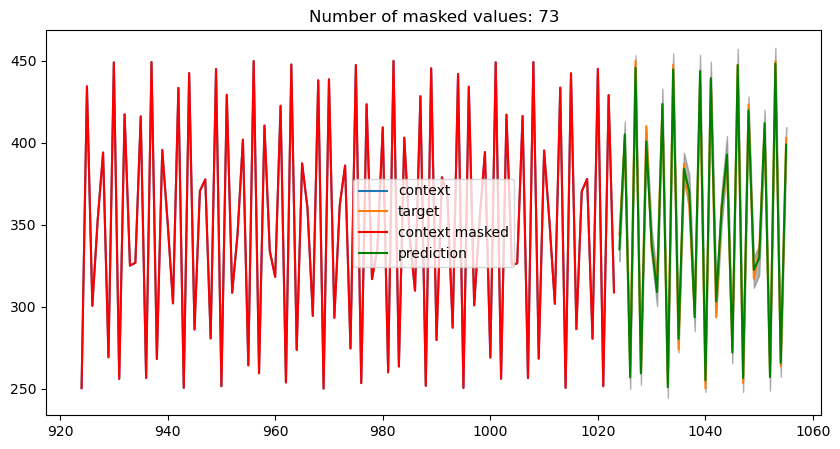

In [45]:
idx = random.randint(0, len(dataset))
input, target = dataset[idx]

context = input.clone()

# Create mask for random input elements
mask = torch.bernoulli(torch.full((input.size(0),), 0.0075)).bool()
n_masked = mask.sum().item()
len_masking = torch.randint(low=1, high=22, size=(n_masked,))
idx_masked = mask.nonzero()
for idx, length in zip(idx_masked, len_masking):
  end = min(idx + length.item(), input.size(0))
  mask[idx:end] = True
input[mask] = float('nan')
# 
context_masked = input.clone()

input = input.unsqueeze(0).to('cuda')
with torch.no_grad():
  prediction = model.model(input)[0, -1, :, :].detach().cpu().numpy()

median = prediction[:, list(model.model.quantiles).index(0.5)]
lower = prediction[:, list(model.model.quantiles).index(0.1)]
upper = prediction[:, list(model.model.quantiles).index(0.9)]

plt.figure(figsize=(10, 5))

plt.plot(range(len(context))[-100:], context[-100:], label="context")
plt.plot(range(len(context), len(context)+len(target)), target, label="target")

plt.plot(range(len(context))[-100:], context_masked[-100:], label="context masked", color="red")

plt.plot(range(len(context), len(context)+len(target)), median, label="prediction", color="green")
plt.fill_between(range(len(context), len(context)+len(target)), lower, upper, color="grey", alpha=0.6)

plt.title('Number of masked values: '+str(input.isnan().sum().item()))

plt.legend()

# further utils functions for training incorporating missing data

In [26]:
def patch_masker_fully_vectorized(x_patch, init_proba=0.0075, max_len=22):
    """
    Function for incorporating variable-length contiguous masking directly on patches.
    For training PatchFM with missing data.

    Vectorized patch masker that masks contiguous segments of variable lengths.
    x_patch: (bs, patch_num, patch_len)
    init_proba: initial probability of masking a patch element
    max_len: maximum length of contiguous masking
    Returns: x_patch_masked with NaNs in masked positions
    """
    x_patch_masked = x_patch.clone()
    bs, pn, pl = x_patch_masked.shape
    total_len = pn * pl
    
    mask = torch.bernoulli(torch.full((bs, total_len), init_proba, device=x_patch.device)).bool()
    
    if mask.sum().item() == 0:
        return x_patch_masked
    
    batch_indices, col_indices = mask.nonzero(as_tuple=True)
    n_masked = len(batch_indices)
    
    len_masking = torch.randint(low=1, high=max_len, size=(n_masked,), device=x_patch.device)
    
    max_ext = max_len - 1
    extensions = torch.arange(1, max_ext + 1, device=x_patch.device).unsqueeze(0)  # [1, max_ext]
    start_positions = col_indices.unsqueeze(1)  # [n_masked, 1]
    extension_positions = start_positions + extensions  # [n_masked, max_ext]
    
    length_mask = extensions < len_masking.unsqueeze(1)  # [n_masked, max_ext]
    bounds_mask = extension_positions < total_len  # [n_masked, max_ext]
    valid_mask = length_mask & bounds_mask
    
    valid_extensions = extension_positions[valid_mask]
    valid_batch_indices = batch_indices.unsqueeze(1).expand(-1, max_ext)[valid_mask]
    
    if len(valid_extensions) > 0:
        mask[valid_batch_indices, valid_extensions] = True
    
    mask_patch = rearrange(mask, "b (pn pl) -> b pn pl", pl=pl).bool()
    x_patch_masked = x_patch_masked.masked_fill(mask_patch, float('nan'))
    return x_patch_masked

# Training - handling missing data

In [40]:
from torch.utils.data import Dataset
import numpy as np
import random
import torch

class SyntheticTimeSeriesDataset(Dataset):
    def __init__(self, seq_len=96, target_len=96, noise=True):
        self.seq_len = seq_len
        self.target_len = target_len
        self.samples = []
        self.noise = noise

        # --- Utility functions ---
        def add(label, ctx, target):
            self.samples.append((ctx, target, label))

        def get_xs(seq_len, target_len, start=None):
            if start is None:
                start = random.uniform(0, 1000)
            xx = torch.linspace(start, start + seq_len + target_len - 1, seq_len + target_len)
            return xx[:seq_len], xx[seq_len:]

        # === Patterns ===
        
        for abscisse in np.arange(-100, 100, 5):
            for _ in range(500):
                x_ctx, x_target = get_xs(self.seq_len, self.target_len)
                alpha = random.uniform(-10, 10)
                delta = random.uniform(-100, 100)
                sin_scale = random.uniform(1000, 1000000)
                sin_freq = random.uniform(0.01, 0.1)
                factor = random.randint(1, 100)
                ctx = (alpha * x_ctx**2 + delta + sin_scale * torch.sin(sin_freq*x_ctx)) / factor
                target = (alpha * x_target**2 + delta + sin_scale * torch.sin(sin_freq*x_target)) / factor
                add("poly_sin", ctx, target)
        
        for abscisse in np.arange(-1000, 1000, 10):
            for slope in [100, 50, 10, 5, 3, 1, 0.1, 0.05, 0.01, -0.1, -0.5, -1, -3, -5, -10, -50, -100]:
                for amp in [1, 2, 4, 8, 16, 32, 64, 128]:
                        for _ in range(1):
                                x_ctx, x_target = get_xs(self.seq_len, self.target_len)
                                ctx = abscisse + amp * torch.sin(x_ctx * 0.3) + slope * x_ctx
                                target = abscisse + amp * torch.sin(x_target * 0.3) + slope * x_target
                                add("linear_sin", ctx, target)
                        
        
        for abscisse in np.arange(-1000, 1000, 10):
            for _ in range(300):
                x_ctx, x_target = get_xs(self.seq_len, self.target_len)
                freq = random.uniform(0.01, 0.1)
                amp = random.uniform(1, 100)
                ctx = abscisse + amp * torch.sin(x_ctx * freq)
                target = abscisse + amp * torch.sin(x_target * freq)
                add("vary_sin", ctx, target)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        ctx, target, label = self.samples[idx]
        if self.noise:
            ctx += torch.randn_like(ctx) * 0.1
            target += torch.randn_like(target) * 0.1
        return ctx.float(), target.float()

In [ ]:
import torch
import torch.nn as nn
from einops import rearrange
import lightning as L
import torch.optim as optim
from rotary_embedding_torch import RotaryEmbedding
from omegaconf import OmegaConf

import torch
import torch.nn as nn

import time

class RevIN(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.cached_mean = None
        self.cached_std = None

    def forward(self, x, mode: str):
        assert x.dim() == 3, "Input tensor must be (batch, n_patches, patch_len)"

        # Cast to float64 for stable statistics computation
        x64 = x.double()

        if mode == "norm":
            mean, std = self._get_statistics(x64)
            self.cached_mean, self.cached_std = mean.detach(), std.detach()
            out = (x64 - mean) / std

        elif mode == "denorm":
            assert self.cached_mean is not None and self.cached_std is not None, \
                "Call forward(..., 'norm') before 'denorm'"
            out = x64 * self.cached_std + self.cached_mean

        else:
            raise NotImplementedError(f"Mode '{mode}' not implemented.")

        # Convert back to float32 for compatibility with main model
        return out.float()

    def _get_statistics(self, x):
        """
        Numerically stable mean and variance computation using 
        incremental mean and variance along the patch dimension.
        x: (B, P, L) float64
        Returns: mean, std (both (B, P, 1))
        """
        B, P, L = x.shape
        counts = torch.arange(1, P+1, device=x.device).view(1, P, 1) * L

        # Incrementally compute mean
        cumsum_x = torch.cumsum(x.sum(dim=-1, keepdim=True), dim=1)
        mean = cumsum_x / counts

        # Variance: mean of squared deviations from the mean
        # Efficient incremental formula:
        # var_i = (sum(x^2) - 2*mean*sum(x) + count*mean^2)/count
        cumsum_x2 = torch.cumsum((x**2).sum(dim=-1, keepdim=True), dim=1)
        var = (cumsum_x2 - 2 * mean * cumsum_x + counts * mean**2) / counts
        std = torch.sqrt(var + self.eps)

        return mean, std

def fill_nan_with_last_observed(x):
    bs, pn, pl = x.size()
    x = rearrange(x, "b pn pl -> (b pn) pl")
    valid_mask = ~torch.isnan(x)
    x_temp = torch.where(valid_mask, x, torch.zeros_like(x))
    seq_indices = torch.arange(x.size(-1), device=x.device).unsqueeze(0)
    valid_indices = torch.where(valid_mask, seq_indices, torch.tensor(-1, device=x.device))
    last_valid_idx = torch.cummax(valid_indices, dim=-1)[0]
    x = x_temp.gather(-1, torch.clamp(last_valid_idx, min=0))
    x = rearrange(x, "(b pn) pl -> b pn pl", b=bs)
    return x

class RevIN_Nan(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.cached_mean = None
        self.cached_std = None

    def forward(self, x, mode, mask_value=None):
        assert x.dim() == 3, "Input tensor must be (batch, n_patches, patch_len)"

        # Cast to float64 for stable statistics computation
        x64 = x.double()

        if mode == "norm":
            mean, std = self._get_statistics(x64)
            self.cached_mean, self.cached_std = mean.detach(), std.detach()
            out = (x64 - mean) / std
            
            nan_idx = out.isnan()
            if nan_idx.any():
                out = fill_nan_with_last_observed(out)
                if mask_value is not None:
                    out[nan_idx] += mask_value

        elif mode == "denorm":
            assert self.cached_mean is not None and self.cached_std is not None, \
                "Call forward(..., 'norm') before 'denorm'"
            out = x64 * self.cached_std + self.cached_mean

        else:
            raise NotImplementedError(f"Mode '{mode}' not implemented.")

        # Convert back to float32 for compatibility with main model
        return out.float()

    def _get_statistics(self, x):
        """
        Numerically stable mean and variance computation using 
        incremental mean and variance along the patch dimension.
        x: (B, P, L) float64
        Returns: mean, std (both (B, P, 1))
        """
        B, P, L = x.shape

        nan_counts = torch.isnan(x).sum(-1, keepdim=True)
        nan_counts = torch.cumsum(nan_counts, dim=1)

        counts = torch.arange(1, P+1, device=x.device).view(1, P, 1).repeat(B, 1, 1) * L
        counts = counts - nan_counts

        cumsum_x = torch.cumsum(x.nansum(dim=-1, keepdim=True), dim=1)
        mean = cumsum_x / counts

        cumsum_x2 = torch.cumsum((x**2).nansum(dim=-1, keepdim=True), dim=1)
        var = (cumsum_x2 - 2 * mean * cumsum_x + counts * mean**2) / counts
        std = torch.sqrt(var + 1e-5)

        return mean, std

class ResidualBlock(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden_layer = nn.Linear(in_dim, hid_dim)
        self.output_layer = nn.Linear(hid_dim, out_dim)
        self.residual_layer = nn.Linear(in_dim, out_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        hid = self.act(self.hidden_layer(x))
        out = self.output_layer(hid)
        res = self.residual_layer(x)
        out = out+res
        return out
    
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model%n_heads==0, f"d_model ({d_model}) must be divisible by n_heads ({n_heads})"

        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)

        self.out_proj = nn.Linear(d_model, d_model)

        self.dropout = dropout

        self.head_dim = d_model//n_heads
        self.n_heads = n_heads

        self.rope = RotaryEmbedding(dim=self.head_dim//2)
    
    def forward(self, q):
        bs, context, dim = q.size()

        k = q
        v = q

        q = self.WQ(q).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.WK(k).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.WV(v).reshape(bs, -1, self.n_heads, self.head_dim).transpose(1, 2)

        q  = self.rope.rotate_queries_or_keys(q)
        k = self.rope.rotate_queries_or_keys(k)

        values = nn.functional.scaled_dot_product_attention(
            q, k, v, is_causal=True, dropout_p=self.dropout if self.training else 0.0
        )

        values = values.transpose(1, 2).reshape(bs, -1, dim)
        values = self.out_proj(values)
        return values
    
class FeedForward(nn.Module):
    def __init__(self, d_model, dropout=0.1, multiple_of=256):
        super().__init__()

        hidden_dim = d_model*4
        hidden_dim = int(2 * hidden_dim / 3)
        hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

        self.w1 = nn.Linear(d_model, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, d_model, bias=False)
        self.w3 = nn.Linear(d_model, hidden_dim, bias=False)

        self.act = nn.SiLU()
        self.dp = nn.Dropout(dropout)

    def forward(self, x):
        x = self.w2(self.act(self.w1(x)) * self.w3(x))
        return self.dp(x)


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ff = FeedForward(d_model=d_model, dropout=dropout)
    
    def forward(self, x):
        out_attn = self.attn(self.ln1((x)))
        x = x + out_attn
        out = x + self.ff(self.ln2(x))
        return out
    
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerEncoderLayer(d_model=d_model, n_heads=n_heads, dropout=dropout)
                for _ in range(n_layers)
            ]
        )
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.norm(x)

class PatchFM(nn.Module): 
    def __init__(self, seq_len, patch_len, d_model, n_heads, n_layers_encoder, dropout=0.1, quantiles=None):
        super().__init__()
        assert seq_len%patch_len==0, f"seq_len ({seq_len}) should be divisible by patch_len ({patch_len})"
        
        self.seq_len = seq_len
        self.patch_len = patch_len

        self.quantiles = quantiles if quantiles is not None else [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        self.n_quantiles = len(self.quantiles)

        self.revin_base = RevIN()
        self.revin_nan = RevIN_Nan()

        self.proj_embedding = ResidualBlock(in_dim=patch_len, hid_dim=2*patch_len, out_dim=d_model, dropout=dropout)
        self.dp = nn.Dropout(dropout)
        self.transformer_encoder = TransformerEncoder(d_model=d_model, n_heads=n_heads, n_layers=n_layers_encoder, dropout=dropout)

        self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len * self.n_quantiles, dropout=dropout)
        #self.proj_output = ResidualBlock(in_dim=d_model, hid_dim=2*d_model, out_dim=patch_len, dropout=dropout)

        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                m.bias.data.fill_(0.0)
                m.weight.data.fill_(1.0)
    
    def forward(self, x): 
        bs, ws = x.size()

        x = rearrange(x, "b (pn pl) -> b pn pl", pl=self.patch_len)  # Reshape to (bs, patch_num, patch_len)
        if self.training:
            x_patch = x[:, 1:, :].clone().detach()
            
            x_patch = patch_masker_fully_vectorized(x_patch, init_proba=0.0075, max_len=22)

        is_nan = torch.isnan(x).any()
        if is_nan:
            self.revin = self.revin_nan
        else:
            self.revin = self.revin_base
        x = self.revin(x, mode="norm")

        x = self.proj_embedding(x) # bs, pn, d_model
        x = self.dp(x)
        x = self.transformer_encoder(x) # bs, pn, d_model

        forecasting = self.proj_output(x)  # bs, pn, patch_len * n_quantiles
        forecasting = self.revin(forecasting, mode="denorm")

        forecasting = rearrange(forecasting, "b pn (pl q) -> b pn pl q", pl=self.patch_len, q=self.n_quantiles)  # Reshape to (bs, patch_len, n_quantiles)

        if self.training:
            return forecasting, x_patch
        else:
            return forecasting

class MultiQuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()

        if not isinstance(quantiles, torch.Tensor):
            quantiles = torch.tensor(quantiles)

        assert all(0 < q < 1 for q in quantiles), "Quantiles must be in the range (0, 1)"
        self.quantiles = quantiles

    def forward(self, pred, target):
        assert pred.shape[-1] == len(self.quantiles)
        assert target.shape[1] == pred.shape[1] # n_patches
        assert target.shape[2] == pred.shape[2] # patch_len
        self.quantiles = self.quantiles.to(pred.device)
        target = target.unsqueeze(-1) 
        errors = target - pred
        losses = torch.max((self.quantiles - 1) * errors, self.quantiles * errors)
        return losses.mean()

class PatchFMLit(L.LightningModule):
    def __init__(self, config):
        super().__init__()
        
        assert config.epochs >= config.epochs_warmups, "epochs must be greater than epochs_warmups"
        assert config.n_warmups > 0, "n_warmups must be greater than 0"
        assert config.epochs_warmups % config.n_warmups == 0, "number of warmups epochs must be divisible by n_warmups"

        self.model = PatchFM(
            seq_len=config.ws, 
            patch_len=config.patch_len, 
            d_model=config.d_model, 
            n_heads=config.n_heads, 
            n_layers_encoder=config.n_layers_encoder, 
            dropout=config.dropout, 
            quantiles=config.quantiles
        )

        self.criterion = MultiQuantileLoss(self.model.quantiles)
        
        self.ctx = [config.ws // config.n_warmups * i for i in range(1, config.n_warmups + 1)]
        self.n_epochs = config.epochs_warmups // config.n_warmups

        self.save_hyperparameters(config)

    def training_step(self, batch, batch_idx):
        x, y = batch

        current_epoch = self.current_epoch
        ctx = self.ctx[current_epoch // self.n_epochs if current_epoch < len(self.ctx) * self.n_epochs else -1]
        x = x[:, -ctx:]

        prediction, x_patch = self.model(x)
        y = y.unsqueeze(1)
        y = torch.cat([x_patch, y], dim=1)    
        loss = self.criterion(prediction, y)
        self.log("train_loss", loss, sync_dist=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.epochs, eta_min=0)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
    
config = {
    "ws": 1024,
    "patch_len": 32,
    "d_model": 128,
    "n_heads": 4,
    "n_layers_encoder": 3,
    "dropout": 0.1,
    "quantiles": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7 , 0.8, 0.9],

    "lr": 1e-4,
    "epochs": 100,
    "epochs_warmups": 80,
    "n_warmups": 4,
    "train_masking": True,

    "batch_size": 64,
    "num_workers": 21,
    "pin_memory": True
}

cfg = OmegaConf.create(config)
model = PatchFMLit(cfg)

dataset = SyntheticTimeSeriesDataset(seq_len=cfg.ws, target_len=cfg.patch_len, noise=True)

trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.batch_size,
    shuffle=True, num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory)

trainer = L.Trainer(
    max_epochs=cfg.epochs,
    accelerator="cuda",
    devices=1,
    enable_progress_bar=True,
    gradient_clip_val=0.1,
)
trainer.fit(model, trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | PatchFM           | 948 K  | train
1 | criterion | MultiQuantileLoss | 0      | train
--------------------------------------------------------
948 K     Trainable params
24        Non-trainable params
948 K     Total params
3.795     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
